## Part1

### a. 프로젝트의 목표
  - 주어진 속성을 기반으로 환자를 건강 상태이거나, 심혈관 질환을 앓고 있을 것으로 분류하는 프로그램을 만듭니다.
  - 이 문제를 품으로 환자가 자신의 건강 상태에 대해 쉽게 자가 진단하여 심혈관 질환에 대해 적절히 대비토록 할 수 있습니다.

### b. 데이터셋 선정
  - Reference : https://www.kaggle.com/datasets/bhadaneeraj/cardio-vascular-disease-detection
  - 근거
    - 당초 하고자 하였던 헬스케어 도메인
    - 부트캠프 내에서 이미 다뤘던 당뇨나 코로나 등의 데이터셋이 아님
    - 행이 10000개 이상
    - 프로젝트 기간 내에 소화할 수 있을 정도의 적당한 특성 수


### c. 머신러닝 문제 정의 이유
- 심혈관 질환의 유무가 타겟
- 가설은 '각 특성들이 타겟 특성인 심혈관 질환 존재 여부에 영향을 줄 것이다' 이며 예측 모델을 만드는 것과, 각 특성의 영향에 대해 알아보는 것을 주안점으로 둔다.

### d. EDA&전처리
#### - EDA&전처리
우선 https://www.kaggle.com/datasets/bhadaneeraj/cardio-vascular-disease-detection 에서 가져온 데이터셋을 읽어들여 확인합니다.

- 각 특성의 의미는 다음과 같습니다.
  - 나이 | Objective Feature | age | int (days)
  - 키 | Objective Feature | height | int (cm) |
  - 몸무게 | Objective Feature | weight | float (kg) |
  - 성별 | Objective Feature | gender | categorical code |
  - 수축기 혈압 | Examination Feature | ap_hi | int |
  - 이완기 혈압 | Examination Feature | ap_lo | int |
  - 콜레스테롤 | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
  - 혈당 | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
  - 흡연 여부 | Subjective Feature | smoke | binary |
  - 음주 여부 | Subjective Feature | alco | binary |
  - 운동 여부 | Subjective Feature | active | binary |
  - 심혈관 질환 존재 유무 | Target Variable | cardio | binary |

다만 각 특성의 수치의 의미에 대해 적혀있지 않았기 때문에, 수치 값을 예상해야할 필요가 생겼습니다.
binary 값들은 상식적으로 0이면 해당하지않고, 1일 경우 해당하므로 1인 경우 시행하거나 존재한다는 의미로서 받아들입니다.
애매한 값이 세 가지가 있는데, gender, cholesterol, gluc입니다.

cholesterol은 3단계로 구분되므로 아래 reference를 참조하여 LDL이 130mg/dL미만 | 160mg/dL 미만 | 160mg/dL이상 의 3단계로 구분합니다.
https://medicine.yonsei.ac.kr/health/encyclopedia/treat_board.do?mode=view&articleNo=66828&title=LDL+%EC%BD%9C%EB%A0%88%EC%8A%A4%ED%85%8C%EB%A1%A4

gluc 또한 3단계로 구분되므로 아래 reference를 참조하여 공복 혈당이 100mg/dL 미만 | 125mg/dL 미만 | 125mg/dL 이상 의 3단계로 구분합니다.
https://www.amc.seoul.kr/asan/mobile/healthstory/medicalcolumn/medicalColumnDetail.do?medicalColumnId=29383

gender는 일반적으로 남성이 평균 키가 더 큰 경향성을 가지므로 평균키를 통해 추측하고자 합니다.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('./archive/cardio_train.csv', sep=';', index_col=0)

In [3]:
df.shape

(69301, 12)

In [4]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
988,22469,1,155,69.0,130,80,2,2,0,0,1,0
989,14648,1,163,71.0,110,70,1,1,0,0,1,1
990,21901,1,165,70.0,120,80,1,1,0,0,1,0
991,14549,2,165,85.0,120,80,1,1,1,1,1,0
992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [5]:
df.groupby('gender')['height'].mean()

gender
1    161.358659
2    169.952068
Name: height, dtype: float64

따라서 1이 female, 2가 male로 추측할 수 있습니다.

In [6]:
#info를 확인합니다.
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 69301 entries, 988 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69301 non-null  int64  
 1   gender       69301 non-null  int64  
 2   height       69301 non-null  int64  
 3   weight       69301 non-null  float64
 4   ap_hi        69301 non-null  int64  
 5   ap_lo        69301 non-null  int64  
 6   cholesterol  69301 non-null  int64  
 7   gluc         69301 non-null  int64  
 8   smoke        69301 non-null  int64  
 9   alco         69301 non-null  int64  
 10  active       69301 non-null  int64  
 11  cardio       69301 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [7]:
#중복행 확인
df.duplicated().value_counts()

False    69277
True        24
dtype: int64

- age가 days로 책정되어있는 만큼 age를 비롯한 12특성이 전부 동일한 사람이 동시에 존재할 가능성은 매우 희박할 것으로 간주하고 drop합니다.

In [8]:
df.drop_duplicates(inplace=True)
df.shape

(69277, 12)

In [9]:
# 널값 확인
df.isnull().any(axis=1).value_counts()

False    69277
dtype: int64

In [10]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000
mean,19468.871415,1.349597,164.362140,74.205884,128.832787,96.656004,1.366933,1.226525,0.088081,0.053900,0.803975,0.499661
std,2467.386017,0.476846,8.206439,14.384935,154.802512,189.128722,0.680354,0.572330,0.283415,0.225821,0.396990,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17665.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21326.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


age가 최소 10798일인데 height 최소는 55, weight 최소는 10입니다. 만약 소인증이라고 할 경우 55cm에 10kg일 수도 있을 것 같지만 100cm가 넘어가면서 10kg이면 이상치라 볼 수 있을 것입니다. 또한 ap_hi, ap_lo가 마이너스입니다. 이건 존재할 수 없는 수치입니다. 각각의 케이스에 대해 쿼리해줍니다.

In [11]:
#10798일 살았으면 성인이므로, 130cm 미만인 성인(이상치)을 확인해본다.
df.query('height< 130')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
4838,14516,1,100,70.0,100,70,1,1,0,0,1,0
5278,17642,1,120,70.0,120,70,1,1,0,0,1,0
5306,15400,1,120,30.0,110,70,1,1,0,0,1,0
5946,16110,1,120,80.0,120,80,1,1,0,0,1,0
8757,20990,1,122,161.0,120,80,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
93223,18467,1,99,60.0,90,60,1,1,0,0,1,0
94249,14595,1,120,80.0,120,70,2,1,0,0,1,0
94906,16928,2,110,90.0,110,90,1,1,0,0,1,0


In [12]:
#height와 weight가 바뀐듯한 샘플이 많이 보인다. weight가 100초과이며 height가 130미만이며 height가 weight보다 작은 경우 전부 값을 스왑해준다.
mask = (df['weight'] > 100) & (df['height'] < 130) & (df['height'] < df['weight'])
df_whChanged = df.copy()
df_whChanged.loc[mask, ['height']] = df.loc[mask, ['weight']].values.astype('int')
df_whChanged.loc[mask, ['weight']] = df.loc[mask, ['height']].values

df_whChanged[mask]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
8757,20990,1,161,122.0,120,80,1,1,0,0,1,1
11662,17646,2,170,97.0,160,100,1,1,1,0,1,1
18218,19594,1,168,75.0,120,80,1,1,1,0,1,1
21958,17405,1,167,125.0,180,90,1,2,0,0,1,1
28605,19777,1,167,112.0,180,120,1,1,0,1,1,0
34186,19074,1,156,81.0,140,90,1,1,0,0,1,0
39156,15292,1,178,80.0,140,90,3,3,0,0,1,1
64802,19834,1,159,104.0,200,100,3,1,0,0,0,1
85128,17643,1,165,104.0,120,80,1,1,0,0,1,0


In [13]:
df_whChanged.query('height< 130 & height < weight')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
10843,14661,2,70,72.0,120,8,1,1,0,0,1,0
23859,19680,2,74,98.0,140,90,1,1,0,0,1,1
32456,23386,1,55,81.0,130,90,1,1,0,0,1,1
41661,19088,1,60,69.0,110,70,1,1,0,0,0,0
45832,15374,1,72,74.0,150,90,1,1,0,0,1,1
48009,19709,2,65,72.0,130,80,1,1,0,0,0,0
66161,21006,2,68,71.0,120,80,1,1,0,0,1,0
76116,20541,2,67,80.0,120,80,1,1,0,0,0,1
95141,18830,1,57,61.0,130,90,1,1,0,0,1,1


In [14]:
#나머지 중 height가 130 미만이고 weight보다 작은 값인 경우 height에 100을 더한다.
mask2 = (df_whChanged['height']< 130) & (df_whChanged['height'] < df_whChanged['weight'])
df_h100 = df_whChanged.copy()
df_h100.loc[mask2, ['height']] = df_whChanged.loc[mask2, ['height']].apply(lambda x: (x + 100).astype('int'))
df_h100.loc[mask2]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
10843,14661,2,170,72.0,120,8,1,1,0,0,1,0
23859,19680,2,174,98.0,140,90,1,1,0,0,1,1
32456,23386,1,155,81.0,130,90,1,1,0,0,1,1
41661,19088,1,160,69.0,110,70,1,1,0,0,0,0
45832,15374,1,172,74.0,150,90,1,1,0,0,1,1
48009,19709,2,165,72.0,130,80,1,1,0,0,0,0
66161,21006,2,168,71.0,120,80,1,1,0,0,1,0
76116,20541,2,167,80.0,120,80,1,1,0,0,0,1
95141,18830,1,157,61.0,130,90,1,1,0,0,1,1


In [15]:
df_h100.query('height< 130').head(50)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
4838,14516,1,100,70.0,100,70,1,1,0,0,1,0
5278,17642,1,120,70.0,120,70,1,1,0,0,1,0
5306,15400,1,120,30.0,110,70,1,1,0,0,1,0
5946,16110,1,120,80.0,120,80,1,1,0,0,1,0
9721,21405,2,120,80.0,140,80,2,2,0,0,1,0
10142,20579,2,117,78.0,150,90,1,1,1,0,1,1
10412,15859,1,120,80.0,120,80,1,1,0,0,1,0
12381,19698,2,119,89.0,160,90,1,1,0,0,1,1
13227,14618,2,120,80.0,120,80,1,1,0,0,1,0


In [16]:

def bmi(h, w):
  return w / (h / 100)**2 # 예상값으로 수정된 키를 대입한다.

mask3high = bmi(df_h100['height'], df_h100['weight']) > 30 * 2 # 고도 비만의 두배 수치로 명백한 이상치로 간주
mask3low = bmi(df_h100['height'], df_h100['weight']) < 18.5 / 2 # 저체중의 1/2배 수치로 명백한 이상치로 간주
df_h100.loc[mask3high | mask3low]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
3470,23646,2,159,165.0,130,70,1,1,0,0,0,0
4672,17545,1,155,155.0,160,1000,1,1,0,0,1,1
4825,14585,1,159,159.0,100,80,1,1,0,0,1,0
4838,14516,1,100,70.0,100,70,1,1,0,0,1,0
12381,19698,2,119,89.0,160,90,1,1,0,0,1,1
16062,18307,1,110,90.0,120,80,1,1,0,0,1,0
17757,22077,1,137,161.0,150,100,2,1,0,0,0,1
18928,22456,2,71,68.0,120,80,3,1,0,0,1,0
20459,22005,1,67,57.0,120,90,1,1,0,0,1,1


In [17]:
#이상 저의 경우 값을 변경할 기준이 명확하지 않고(*10을 하기도 100을 더하기도 애매하다) 샘플의 수가 적으므로 드롭한다.
df_droplow = df_h100.drop(df_h100[mask3low].index)
df_droplow.loc[mask3low]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,


In [18]:
mask3_under100 = df_droplow['height'] < 100
df_hplus100 = df_droplow.copy()
df_hplus100.loc[mask3high & mask3_under100, ['height']] = df_droplow.loc[mask3high & mask3_under100, ['height']].apply(lambda x : x + 100)
df_hplus100.loc[mask3high & mask3_under100]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
18928,22456,2,171,68.0,120,80,3,1,0,0,1,0
20459,22005,1,167,57.0,120,90,1,1,0,0,1,1
21686,15812,1,170,68.0,120,80,1,1,0,0,0,0
32207,14538,1,168,65.0,100,60,1,1,0,0,0,0
39462,20978,1,164,61.0,130,70,1,1,0,0,1,0
41075,19747,1,191,55.0,140,90,1,1,0,0,1,1
63545,19120,1,165,60.0,120,80,1,1,0,0,1,0
67631,23297,1,175,75.0,120,80,1,1,0,0,1,0
72476,14499,2,167,60.0,110,80,1,1,1,1,1,0


In [19]:
# ap_hi 값이 0미만
mask4_ap_hi_minus = df_hplus100['ap_hi'] <0
df_hplus100.loc[mask4_ap_hi_minus]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
6525,15281,1,165,78.0,-100,80,2,1,0,0,1,0
22881,22108,2,161,90.0,-115,70,1,1,0,0,1,0
29313,15581,1,153,54.0,-100,70,1,1,0,0,1,0
34295,18301,1,162,74.0,-140,90,1,1,0,0,1,1
36025,14711,2,168,50.0,-120,80,2,1,0,0,0,1
50055,23325,2,168,59.0,-150,80,1,1,0,0,1,1
66571,23646,2,160,59.0,-120,80,1,1,0,0,0,0


In [20]:
# ap_hi에 -가 잘못 붙은 것으로 보이므로 전부 +로 바꿔준다. abs로 하면 될 듯하다.
df_ap_hi_abs = df_hplus100.copy()
df_ap_hi_abs['ap_hi'] = abs(df_hplus100['ap_hi'])
df_ap_hi_abs.loc[mask4_ap_hi_minus]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
6525,15281,1,165,78.0,100,80,2,1,0,0,1,0
22881,22108,2,161,90.0,115,70,1,1,0,0,1,0
29313,15581,1,153,54.0,100,70,1,1,0,0,1,0
34295,18301,1,162,74.0,140,90,1,1,0,0,1,1
36025,14711,2,168,50.0,120,80,2,1,0,0,0,1
50055,23325,2,168,59.0,150,80,1,1,0,0,1,1
66571,23646,2,160,59.0,120,80,1,1,0,0,0,0


In [21]:
# ap_hi 값이 90 / 2 = 45 이하(수축기 저혈압 기준)
mask4_ap_hi_low = df_ap_hi_abs['ap_hi'] <= 45
df_ap_hi_abs[mask4_ap_hi_low]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
1294,21867,2,175,70.0,14,90,3,1,0,0,1,1
1360,18225,1,172,65.0,11,80,1,3,0,0,1,0
2260,19201,1,165,66.0,12,80,1,1,0,0,1,0
2301,22591,1,165,71.0,14,80,1,1,0,0,1,1
2505,14365,2,168,64.0,11,60,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
98039,21217,1,160,59.0,12,80,1,1,0,0,1,0
98213,18755,1,158,74.0,14,90,1,1,0,0,1,1
98568,19107,1,154,77.0,14,90,1,1,0,0,1,0


In [22]:
# ap_hi 나머지 값은 0이 하나 빠진 듯이 보인다. * 10 해준다.
df_ap_hi_mul10 = df_ap_hi_abs.copy()
df_ap_hi_mul10['ap_hi'] = df_ap_hi_abs['ap_hi'].apply(lambda x: x * 10 if x < 45 else x )
df_ap_hi_mul10[mask4_ap_hi_low]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
1294,21867,2,175,70.0,140,90,3,1,0,0,1,1
1360,18225,1,172,65.0,110,80,1,3,0,0,1,0
2260,19201,1,165,66.0,120,80,1,1,0,0,1,0
2301,22591,1,165,71.0,140,80,1,1,0,0,1,1
2505,14365,2,168,64.0,110,60,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
98039,21217,1,160,59.0,120,80,1,1,0,0,1,0
98213,18755,1,158,74.0,140,90,1,1,0,0,1,1
98568,19107,1,154,77.0,140,90,1,1,0,0,1,0


In [23]:
#그럼에도 ap_hi가 45이하이면 활용하기 매우 어려우므로 45초과 값만 남깁니다.
df_ap_hi_over45 = df_ap_hi_mul10.query('ap_hi > 45')
df_ap_hi_over45

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
988,22469,1,155,69.0,130,80,2,2,0,0,1,0
989,14648,1,163,71.0,110,70,1,1,0,0,1,1
990,21901,1,165,70.0,120,80,1,1,0,0,1,0
991,14549,2,165,85.0,120,80,1,1,1,1,1,0
992,23393,1,155,62.0,120,80,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
99996,19066,2,183,105.0,180,90,3,1,0,1,0,1


In [24]:
# ap_hi 값이 160(고혈압 2단계) * 3 = 480 초과
mask4_ap_hi_high = df_ap_hi_over45['ap_hi'] > 480
df_ap_hi_over45[mask4_ap_hi_high]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
2654,15116,1,160,60.0,902,60,1,1,0,0,1,0
2845,22712,2,167,59.0,906,0,1,1,0,0,1,0
6822,14425,1,168,63.0,909,60,2,1,0,0,1,0
11089,21032,1,175,80.0,11500,90,1,1,0,0,1,1
12710,18870,1,164,75.0,1420,80,2,1,0,0,1,1
13616,22659,1,155,87.0,701,110,1,1,0,0,1,1
19827,15996,1,168,72.0,1500,80,1,1,0,0,1,1
25314,22398,2,163,50.0,907,70,3,3,0,0,1,1
34120,16131,1,161,92.0,906,0,2,1,0,0,1,1


In [25]:
#10000 이상은 /100, 10000미만은 /10으로 바꾸고 int로 변경하자.
def change10_100(x):
  if x >= 10000:
    return int(x / 100)
  elif x < 480:
    return int(x)
  return int(x / 10)
df_ap_hi_div10_100 = df_ap_hi_over45.copy()
df_ap_hi_div10_100.loc[mask4_ap_hi_high, ['ap_hi']] = df_ap_hi_over45['ap_hi'].loc[mask4_ap_hi_high].apply(change10_100)
df_ap_hi_div10_100[mask4_ap_hi_high]



,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
2654,15116,1,160,60.0,90,60,1,1,0,0,1,0
2845,22712,2,167,59.0,90,0,1,1,0,0,1,0
6822,14425,1,168,63.0,90,60,2,1,0,0,1,0
11089,21032,1,175,80.0,115,90,1,1,0,0,1,1
12710,18870,1,164,75.0,142,80,2,1,0,0,1,1
13616,22659,1,155,87.0,70,110,1,1,0,0,1,1
19827,15996,1,168,72.0,150,80,1,1,0,0,1,1
25314,22398,2,163,50.0,90,70,3,3,0,0,1,1
34120,16131,1,161,92.0,90,0,2,1,0,0,1,1


In [26]:
# ap_lo 값이 0미만
mask5_ap_lo_minus = df_ap_hi_div10_100['ap_lo'] <0
df_ap_hi_div10_100.loc[mask5_ap_lo_minus]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
85816,22571,1,167,74.0,150,-70,1,1,0,0,1,1


In [27]:
# ap_lo에 -가 잘못 붙은 것으로 보이므로 전부 +로 바꿔준다. abs로 하면 될 듯하다.
df_ap_lo_abs = df_ap_hi_div10_100.copy()
df_ap_lo_abs['ap_lo'] = abs(df_ap_hi_div10_100['ap_lo'])
df_ap_lo_abs.loc[mask5_ap_lo_minus]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
85816,22571,1,167,74.0,150,70,1,1,0,0,1,1


In [28]:
# ap_lo가 0인 경우
mask5_ap_lo_0 = df_ap_lo_abs['ap_lo'] == 0
df_ap_lo_abs[mask5_ap_lo_0]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
2845,22712,2,167,59.0,90,0,1,1,0,0,1,0
19258,14965,2,150,60.0,130,0,1,1,0,0,0,0
23512,20457,1,156,50.0,138,0,3,1,0,0,1,1
24837,18226,1,164,78.0,138,0,1,1,0,0,1,0
32749,21182,2,166,68.0,149,0,1,1,0,0,1,1
34120,16131,1,161,92.0,90,0,2,1,0,0,1,1
36325,17952,2,176,73.0,120,0,1,1,0,0,1,0
39577,23396,2,180,73.0,140,0,1,1,1,1,1,1
45400,16070,1,170,64.0,90,0,1,1,0,0,1,0


In [29]:
#ap_lo가 0인 샘플 수가 꽤 되지만 총 샘플수에 비해 0.03%정도로 적은 양이므로 과감히 드롭한다.
print(mask5_ap_lo_0.value_counts()[True] / mask5_ap_lo_0.count()) # 0.03%
df_ap_lo_drop0 = df_ap_lo_abs.drop(df_ap_lo_abs[mask5_ap_lo_0].index)
df_ap_lo_drop0

0.00030315716533614356


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
988,22469,1,155,69.0,130,80,2,2,0,0,1,0
989,14648,1,163,71.0,110,70,1,1,0,0,1,1
990,21901,1,165,70.0,120,80,1,1,0,0,1,0
991,14549,2,165,85.0,120,80,1,1,1,1,1,0
992,23393,1,155,62.0,120,80,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
99996,19066,2,183,105.0,180,90,3,1,0,1,0,1


In [30]:
# ap_lo 값이 60 / 2 = 30 이하(이완기 저혈압 기준)
mask5_ap_lo_low = df_ap_lo_drop0['ap_lo'] <= 30
df_ap_lo_drop0.loc[mask5_ap_lo_low]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
7590,20984,1,164,102.0,120,30,2,1,0,0,1,0
9610,16705,1,156,61.0,150,10,1,1,0,0,0,1
10843,14661,2,170,72.0,120,8,1,1,0,0,1,0
12550,21155,1,162,68.0,110,20,1,1,0,0,1,0
13943,21802,1,166,125.0,120,8,3,1,0,0,1,1
14410,18334,1,152,50.0,150,10,3,1,0,0,1,1
16884,18171,1,169,69.0,128,20,1,1,0,0,1,1
19885,18007,1,164,74.0,110,20,1,1,0,0,1,0
26983,17531,1,171,68.0,110,7,1,1,0,0,1,0


In [31]:
#이완기 혈압에 * 10을 해주고 , 그럼에도 수축기 혈압을 넘지 않는 경우 해당 값을 적용한다. *10한 값도 이완기 이상치인 30이하면 그값은 그냥 버린다.
mask5_ap_lo_low.value_counts(normalize=True) # 이완기 30이하값이 0.05% 정도, 이완기 30 이하에 해당하는 값은 사실 다 드롭해도 상관없다.
df_ap_lo_mul10 = df_ap_lo_drop0.copy()
df_ap_lo_mul10.loc[(df_ap_lo_drop0['ap_hi'] > df_ap_lo_drop0['ap_lo'] * 10), ['ap_lo']] = df_ap_lo_drop0.loc[(df_ap_lo_drop0['ap_hi'] > df_ap_lo_drop0['ap_lo'] * 10)]['ap_lo'].apply(lambda x : x * 10)
df_ap_lo_mul10

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
988,22469,1,155,69.0,130,80,2,2,0,0,1,0
989,14648,1,163,71.0,110,70,1,1,0,0,1,1
990,21901,1,165,70.0,120,80,1,1,0,0,1,0
991,14549,2,165,85.0,120,80,1,1,1,1,1,0
992,23393,1,155,62.0,120,80,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
99996,19066,2,183,105.0,180,90,3,1,0,1,0,1


In [32]:
#아직도 이완기 혈압이 30이하면 값을 활용하기 매우 어려우므로 드롭한다.
df_ap_lo_over30 = df_ap_lo_mul10.drop(df_ap_lo_mul10[df_ap_lo_mul10['ap_lo'] <= 30].index)
df_ap_lo_over30

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
988,22469,1,155,69.0,130,80,2,2,0,0,1,0
989,14648,1,163,71.0,110,70,1,1,0,0,1,1
990,21901,1,165,70.0,120,80,1,1,0,0,1,0
991,14549,2,165,85.0,120,80,1,1,1,1,1,0
992,23393,1,155,62.0,120,80,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
99996,19066,2,183,105.0,180,90,3,1,0,1,0,1


In [33]:
# 이완기 고혈압 100 * 3 = 300 초과를 이상치로 분류
mask5_ap_lo_over300 = df_ap_lo_over30['ap_lo'] > 300
df_ap_lo_over30.loc[mask5_ap_lo_over300]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
1015,23407,2,170,74.0,140,1000,1,1,0,0,1,1
1229,17405,2,170,84.0,150,1100,1,1,1,0,0,1
1389,21043,2,168,82.0,160,1000,2,1,0,0,0,1
1438,15906,1,167,71.0,150,1001,2,1,0,0,1,1
1494,21107,2,169,76.0,140,1000,3,3,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99659,23330,1,167,81.0,160,1000,1,1,0,0,1,1
99798,21808,1,152,56.0,160,1000,1,1,0,0,1,1
99807,21239,2,168,95.0,160,1000,1,1,0,0,1,1


In [34]:
df_ap_lo_div10_100 = df_ap_lo_over30.copy()
#10000 이상은 /100, 10000미만은 /10으로 바꾸고 int로 변경하자.
def change10_100(x):
  if x >= 3000: # 이완기 고혈압 100 * 3 * 10
    return int(x / 100)
  elif x < 300:
    return int(x)
  return int(x / 10)
df_ap_lo_div10_100 = df_ap_lo_over30.copy()
df_ap_lo_div10_100.loc[mask5_ap_lo_over300, ['ap_lo']] = df_ap_lo_over30['ap_lo'].loc[mask5_ap_lo_over300].apply(change10_100)
df_ap_lo_div10_100[mask5_ap_lo_over300]


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
1015,23407,2,170,74.0,140,100,1,1,0,0,1,1
1229,17405,2,170,84.0,150,110,1,1,1,0,0,1
1389,21043,2,168,82.0,160,100,2,1,0,0,0,1
1438,15906,1,167,71.0,150,100,2,1,0,0,1,1
1494,21107,2,169,76.0,140,100,3,3,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99659,23330,1,167,81.0,160,100,1,1,0,0,1,1
99798,21808,1,152,56.0,160,100,1,1,0,0,1,1
99807,21239,2,168,95.0,160,100,1,1,0,0,1,1


In [35]:
#수축기 혈압이 이완기 혈압이 높은 경우를 이상치로 간주합니다.
df_ap_lo_div10_100[df_ap_lo_div10_100['ap_hi'] < df_ap_lo_div10_100['ap_lo']].describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,19439.550459,1.412844,164.733945,75.889908,88.165138,132.018349,1.403670,1.412844,0.119266,0.229358,0.779817,0.605505
std,2394.160637,0.494619,9.057064,13.009498,17.195237,22.496083,0.746836,0.772334,0.325598,0.422362,0.416284,0.491000
min,14375.000000,1.000000,148.000000,51.000000,70.000000,80.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17674.000000,1.000000,159.000000,66.000000,80.000000,120.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19595.000000,1.000000,164.000000,74.000000,80.000000,130.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,21200.000000,2.000000,171.000000,84.000000,90.000000,140.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23478.000000,2.000000,188.000000,117.000000,170.000000,190.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
mask6 = df_ap_lo_div10_100['ap_hi'] < df_ap_lo_div10_100['ap_lo']
df_ap_lo_div10_100[mask6]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
3356,23361,1,154,102.0,90,150,1,1,0,0,0,1
4214,21957,2,182,90.0,80,140,3,3,0,0,1,1
4880,19992,2,180,80.0,80,125,3,3,1,1,1,1
5130,21874,1,160,83.0,80,120,1,1,0,0,1,0
6836,19618,2,164,89.0,90,140,2,2,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
94673,22551,1,169,88.0,100,160,3,3,0,0,0,1
95164,19498,2,160,81.0,80,120,3,3,1,1,1,1
96271,23424,1,153,74.0,80,130,1,1,0,0,1,1


In [37]:
#단순히 뒤집힌 것으로 간주하고 수치를 스왑합니다.
df_swap_lo_hi = df_ap_lo_div10_100.copy()
df_swap_lo_hi.loc[mask6, ['ap_hi', 'ap_lo']] = df_ap_lo_div10_100.loc[mask6, ['ap_lo', 'ap_hi']].values
df_swap_lo_hi.loc[mask6]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
3356,23361,1,154,102.0,150,90,1,1,0,0,0,1
4214,21957,2,182,90.0,140,80,3,3,0,0,1,1
4880,19992,2,180,80.0,125,80,3,3,1,1,1,1
5130,21874,1,160,83.0,120,80,1,1,0,0,1,0
6836,19618,2,164,89.0,140,90,2,2,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
94673,22551,1,169,88.0,160,100,3,3,0,0,0,1
95164,19498,2,160,81.0,120,80,3,3,1,1,1,1
96271,23424,1,153,74.0,130,80,1,1,0,0,1,1


In [38]:
#weight 내에 이상치를 다시 확인합니다.
df_swap_lo_hi['weight'].sort_values().unique()

array([ 23.  ,  28.  ,  29.  ,  30.  ,  31.  ,  32.  ,  33.  ,  34.  ,
        35.  ,  35.45,  36.  ,  37.  ,  38.  ,  39.  ,  40.  ,  41.  ,
        42.  ,  42.2 ,  43.  ,  44.  ,  45.  ,  45.8 ,  46.  ,  47.  ,
        48.  ,  49.  ,  50.  ,  50.5 ,  50.7 ,  51.  ,  51.5 ,  52.  ,
        52.3 ,  53.  ,  53.2 ,  53.3 ,  53.5 ,  53.6 ,  53.67,  53.9 ,
        54.  ,  54.35,  54.5 ,  54.9 ,  55.  ,  55.2 ,  55.4 ,  55.6 ,
        56.  ,  56.2 ,  57.  ,  57.4 ,  57.6 ,  57.8 ,  58.  ,  58.5 ,
        58.7 ,  58.8 ,  59.  ,  59.2 ,  59.5 ,  59.8 ,  60.  ,  60.1 ,
        60.2 ,  60.5 ,  60.6 ,  61.  ,  61.2 ,  61.3 ,  61.5 ,  62.  ,
        62.2 ,  62.3 ,  62.4 ,  62.5 ,  62.7 ,  63.  ,  63.4 ,  63.8 ,
        63.82,  64.  ,  64.1 ,  64.3 ,  64.5 ,  64.7 ,  65.  ,  65.3 ,
        65.5 ,  66.  ,  66.3 ,  66.4 ,  66.5 ,  67.  ,  67.3 ,  67.5 ,
        67.8 ,  67.9 ,  68.  ,  68.2 ,  68.3 ,  68.4 ,  68.5 ,  68.9 ,
        69.  ,  69.5 ,  69.8 ,  70.  ,  70.2 ,  70.3 ,  70.5 ,  70.7 ,
      

In [39]:
# 사실 weight가 height 값을 넘기는 굉장히 어렵지만, 실존하는 사례인 것을 고려하여 그냥 남겨두기로 했습니다.
df_swap_lo_hi[df_swap_lo_hi['weight'] > df_swap_lo_hi['height']] 

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
3470,23646,2,159,165.0,130,70,1,1,0,0,0,0
6716,17218,2,176,180.0,140,90,1,1,0,0,1,1
17757,22077,1,137,161.0,150,100,2,1,0,0,0,1
27063,15421,1,155,163.0,180,100,1,1,0,0,1,1
28683,20656,2,165,178.0,120,80,1,1,1,1,1,0
52564,19630,1,161,181.0,180,110,2,1,0,0,1,1
53670,19909,1,162,175.0,140,100,1,1,0,0,1,1
58175,21728,1,154,162.0,120,80,1,1,0,0,1,0
71945,15117,2,180,200.0,150,90,1,1,0,0,1,1


In [40]:
# 데이터가 전처리가 끝났으므로 변수명을 적당히 변경해 지정해줍니다.
df_cleaned = df_swap_lo_hi
df_cleaned.shape


(69229, 12)

In [41]:
#상관계수를 알아보고 가설을 세우기 전에 일단 train, val, test 셋으로 나눕니다.
from sklearn.model_selection import train_test_split



df_nonTest, df_test = train_test_split(df_cleaned, test_size= 0.2, random_state=42)
df_train, df_val = train_test_split(df_nonTest, test_size= 0.2, random_state=42)


In [42]:
# 일단 데이터 리포트를 만들어 봅니다.
from pandas_profiling import ProfileReport
profile = ProfileReport(df_train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
#상관계수를 통해 가설을 간단하게 세워봅니다.
df_train.corr().sort_values('cardio')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
active,-0.008896,0.008939,-0.004403,-0.010642,0.004934,0.008119,0.008606,-0.009855,0.021870,0.023727,1.000000,-0.038974
smoke,-0.045710,0.340406,0.191922,0.064375,0.029642,0.023953,0.006938,-0.008677,1.000000,0.342916,0.021870,-0.013812
height,-0.080294,0.515285,1.000000,0.308211,0.020652,0.036083,-0.053879,-0.022189,0.191922,0.100809,-0.004403,-0.011263
alco,-0.025860,0.177575,0.100809,0.074865,0.036437,0.038979,0.030299,0.009451,0.342916,1.000000,0.023727,-0.008168
gender,-0.023162,1.000000,0.515285,0.157731,0.063240,0.065578,-0.034433,-0.019879,0.340406,0.177575,0.008939,0.006738
gluc,0.102832,-0.019879,-0.022189,0.104896,0.092737,0.071828,0.451883,1.000000,-0.008677,0.009451,-0.009855,0.089216
weight,0.061671,0.157731,0.308211,1.000000,0.270122,0.252429,0.143756,0.104896,0.064375,0.074865,-0.010642,0.178962
cholesterol,0.155197,-0.034433,-0.053879,0.143756,0.193406,0.163722,1.000000,0.451883,0.006938,0.030299,0.008606,0.221084
age,1.000000,-0.023162,-0.080294,0.061671,0.209610,0.159506,0.155197,0.102832,-0.045710,-0.025860,-0.008896,0.240033
ap_lo,0.159506,0.065578,0.036083,0.252429,0.741615,1.000000,0.163722,0.071828,0.023953,0.038979,0.008119,0.344959


- ap_hi, ap_lo, age 순으로 영향이 있을 것으로 추측됩니다.

## Part 2

### a. 모델 학습 및 검증

In [44]:
# 각각 타겟과 특성들로 나눕니다.

target = 'cardio'
X_test = df_test.drop(columns=target)
y_test = df_test[target]
X_val = df_val.drop(columns=target)
y_val = df_val[target]
X_train = df_train.drop(columns=target)
y_train = df_train[target]

In [94]:
#기준 모델을 구합니다.
y_train_base_acc = y_train.value_counts(normalize=True)[1]
y_train_base_acc

0.5018959057464001

현재 사용하는 데이터는 이미 전부 수치화된 데이터입니다. 또한 결측 데이터가 없습니다. 그러므로 encoding과 imputing이 필요하지 않습니다.

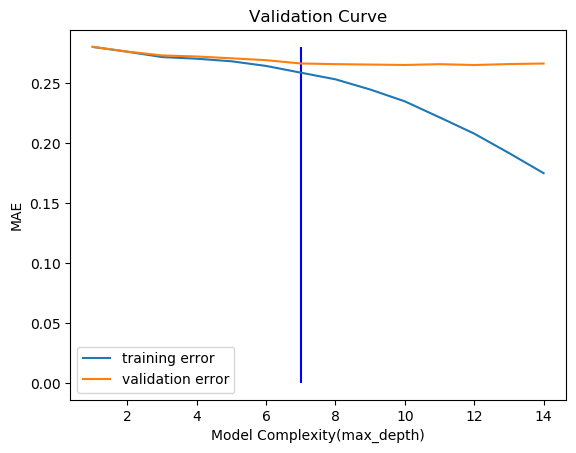

In [67]:
#랜덤 포레스트를 활용해봅니다.

import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

depth = range(1, 15, 1)
ts, vs = validation_curve(
    rfc, X_train, y_train
    , param_name='max_depth'
    , param_range=depth, scoring='neg_mean_absolute_error'
    , cv=3
    , n_jobs=-1
)

train_scores_mean = np.mean(-ts, axis=1)
validation_scores_mean = np.mean(-vs, axis=1)

fig, ax = plt.subplots()

# 훈련세트 검증곡선
ax.plot(depth, train_scores_mean, label='training error')

# 검증세트 검증곡선
ax.plot(depth, validation_scores_mean, label='validation error')

# 이상적인 max_depth
ax.vlines(7,0, train_scores_mean.max(), color='blue')

# 그래프 셋팅
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(max_depth)', ylabel='MAE')
ax.legend()
fig.dpi = 100

In [69]:
#RandomizedSearchCV를 활용하여 최선의 모델을 찾아봅니다.

from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV


dists = {
    'n_estimators': randint(50, 500), 
    # 'randomforestregressor__max_depth': [5, 10, 15, 20, None],  # max depth는 7이 제일 적절할 것으로 구했습니다.
    'max_features': uniform(0, 1), # max_features
    'class_weight' : ['balanced', 'balanced_subsample', None]
}

clf = RandomizedSearchCV(
    rfc, 
    param_distributions=dists, 
    n_iter=10, 
    cv=3, 
    scoring='f1',  
    verbose=10,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [70]:
# 10가지 패러미터의 랜덤포레스트 모델을 f1스코어순으로 나열합니다. 
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,1,5,4,3,7,9,8,2,6,0
mean_fit_time,18.221998,13.809331,23.969998,14.427331,6.396332,12.467998,39.446331,29.021331,4.282334,9.259999
std_fit_time,2.165881,1.811659,0.099205,0.956467,0.177246,4.736717,0.446803,1.169688,0.076883,0.483244
mean_score_time,4.460001,1.734001,3.189667,3.883001,2.057333,1.779668,2.969667,3.319666,1.313,1.545
std_score_time,0.86907,0.288759,0.848409,0.4972,0.874336,1.14891,0.350587,0.843141,0.282974,0.163343
param_class_weight,balanced,None,balanced,balanced,None,balanced,balanced_subsample,None,None,balanced_subsample
param_max_features,0.201089,0.53437,0.413382,0.019578,0.175855,0.675522,0.674661,0.951602,0.549947,0.730441
param_n_estimators,453,243,452,428,216,191,436,273,51,88
params,"{'class_weight': 'balanced', 'max_features': 0...","{'class_weight': None, 'max_features': 0.53436...","{'class_weight': 'balanced', 'max_features': 0...","{'class_weight': 'balanced', 'max_features': 0...","{'class_weight': None, 'max_features': 0.17585...","{'class_weight': 'balanced', 'max_features': 0...","{'class_weight': 'balanced_subsample', 'max_fe...","{'class_weight': None, 'max_features': 0.95160...","{'class_weight': None, 'max_features': 0.54994...","{'class_weight': 'balanced_subsample', 'max_fe..."
split0_test_score,0.711159,0.710952,0.709521,0.708976,0.707332,0.71051,0.710653,0.708869,0.708378,0.706547
split1_test_score,0.714354,0.711943,0.713267,0.713529,0.713235,0.71133,0.710201,0.707952,0.707446,0.706354


In [79]:
#최상의 모델입니다.
clf.best_estimator_

RandomForestClassifier(class_weight='balanced',
                       max_features=0.20108887686877197, n_estimators=453,
                       n_jobs=-1, random_state=42)

In [105]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
round_digit = 4
y_val_pred_rfc = clf.predict(X_val)
print(classification_report(y_val, y_val_pred_rfc, digits=round_digit))
print(f'정확도가 기준 모델({round(y_train_base_acc, round_digit)})보다 높다 => ', accuracy_score(y_val, y_val_pred_rfc) > y_train_base_acc)

val_f1 = f1_score(y_val, y_val_pred_rfc)

              precision    recall  f1-score   support

           0     0.7172    0.7182    0.7177      5547
           1     0.7170    0.7159    0.7164      5530

    accuracy                         0.7171     11077
   macro avg     0.7171    0.7171    0.7171     11077
weighted avg     0.7171    0.7171    0.7171     11077

정확도가 기준 모델(0.5019)보다 높다 =>  True


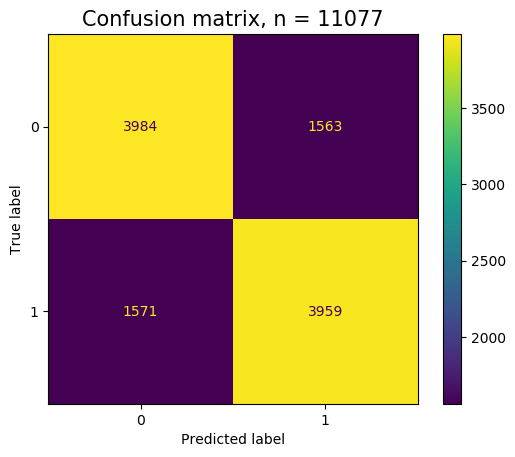

In [81]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pcm = ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_rfc)
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [101]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    clf.best_estimator_, # model
    scoring='f1', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=42
)


# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val, y_val);

In [103]:
#permutaion importance를 확인합니다.

feature_names = X_val.columns.tolist()
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1204 ± 0.0089,ap_hi
0.0233 ± 0.0035,age
0.0207 ± 0.0024,cholesterol
0.0006 ± 0.0018,smoke
0.0004 ± 0.0017,alco
0.0002 ± 0.0037,weight
0.0002 ± 0.0025,gluc
0.0001 ± 0.0029,active
-0.0000 ± 0.0053,gender
-0.0006 ± 0.0039,ap_lo


- 랜덤포레스트 결과, 결론적으로 가장 중요한 값은 ap_hi이고, 그 다음 age, 콜레스테롤 순이 되며, 나머지 특성은 생각보다 큰 영향이 없습니다.

              precision    recall  f1-score   support

           0     0.7228    0.7169    0.7198      7019
           1     0.7114    0.7173    0.7143      6827

    accuracy                         0.7171     13846
   macro avg     0.7171    0.7171    0.7171     13846
weighted avg     0.7171    0.7171    0.7171     13846



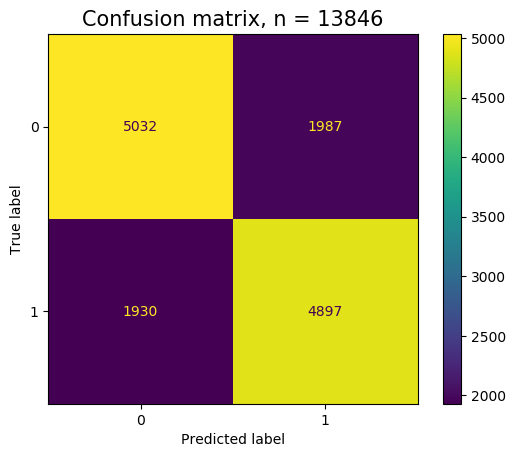

검증 셋 f1 값 :  0.7164314151284836
테스트 셋 f1 값 :  0.7143169717744876


In [106]:
from sklearn.metrics import classification_report, accuracy_score
round_digit = 4
y_test_pred_rfc = clf.predict(X_test)
print(classification_report(y_test, y_test_pred_rfc, digits=round_digit))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pcm = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_rfc)
plt.title(f'Confusion matrix, n = {len(y_test)}', fontsize=15)
plt.show()

test_f1 = f1_score(y_test, y_test_pred_rfc)

print('검증 셋 f1 값 : ', val_f1)
print('테스트 셋 f1 값 : ', test_f1)